# Data Parameters
Input

- Frames: 5 in 5 out
- Target: 8 stations
- Channels: AirNow + Wind U + V + AOD + temporal encodings

Model
- Temporal

Result

General Notes

In [1]:
# file locations
import sys
sys.path.append("/home/mgraca/Workspace/hrrr-smoke-viz") # for libs.plotting
model_checkpoint_file = '/home/mgraca/Workspace/hrrr-smoke-viz/pwwb-experiments/tensorflow/experiment_output/basic_experiments/model.keras'
data_path = "/home/mgraca/Workspace/hrrr-smoke-viz/pwwb-experiments/tensorflow/final_input_data/two_years_sat_data/"

# Data parameters
START_DATE = "2023-12-01-00"
END_DATE = "2025-12-01-00"

# Define bounding box
lat_bottom, lat_top = 33.5, 34.5
lon_bottom, lon_top = -118.75, -117.0
extent = (lon_bottom, lon_top, lat_bottom, lat_top)

# Input data shape
dim = 40
frames_per_sample = 5
EPOCHS = 100
BATCH_SIZE = 32

print(f"{extent}")
print(f"Grid dimension: {dim}x{dim}")
print(f"Frames per sample: {frames_per_sample}")

(-118.75, -117.0, 33.5, 34.5)
Grid dimension: 40x40
Frames per sample: 5


# Data Ingestion and Preprocessing

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import os
from datetime import datetime

In [3]:
X_test_files =  ["AirNow_PM25_X_test.npy",  "GOES_AOD_X_test.npy",  "METAR_Wind_U_X_test.npy",  "METAR_Wind_V_X_test.npy" ]
X_train_files = ["AirNow_PM25_X_train.npy", "GOES_AOD_X_train.npy", "METAR_Wind_U_X_train.npy", "METAR_Wind_V_X_train.npy"]
X_valid_files = ["AirNow_PM25_X_valid.npy", "GOES_AOD_X_valid.npy", "METAR_Wind_U_X_valid.npy", "METAR_Wind_V_X_valid.npy"]

Y_test_files = "Y_test.npy"
Y_train_files = "Y_train.npy"
Y_valid_files = "Y_valid.npy"

In [4]:
''' y is not trimmed, can't use this method. You'd need to trim the sensor data and save it first.
BATCH_SIZE = 32
X_training_files_paths = [f"{data_path + file}" for file in X_train_files]
Y_training_files_paths = f"{data_path + Y_train_files}"
generator = PWWBPyDataset(X_training_files_paths, Y_training_files_paths, BATCH_SIZE, workers=8, use_multiprocessing=True)

history = seq.fit(
    generator,
    epochs=EPOCHS,
    validation_data=(X_valid, Y_valid),
    callbacks=callbacks
)
'''
X_train = np.stack([np.load(f"{data_path + file}") for file in X_train_files], axis=-1)
X_test = np.stack([np.load(f"{data_path + file}") for file in X_test_files], axis=-1)
X_valid = np.stack([np.load(f"{data_path + file}") for file in X_valid_files], axis=-1)

Y_train = np.load(f"{data_path + Y_train_files}")
Y_test = np.load(f"{data_path + Y_test_files}")
Y_valid = np.load(f"{data_path + Y_valid_files}")

In [5]:
X_train_2 = np.load(f"{data_path + "Temporal_Encoding_X_train.npy"}")
X_test_2 = np.load(f"{data_path + "Temporal_Encoding_X_test.npy"}")
X_valid_2 = np.load(f"{data_path + "Temporal_Encoding_X_valid.npy"}")

In [6]:
# 5 frames in, one frame and one station out
# next frame = 0 (:1)
# LA station = 4, Compton = 5
sensors = [
    'Simi Valley - Cochran Street', 'Reseda', 'Santa Clarita', 
    'North Holywood', 'Los Angeles - N. Main Street', 'Compton', 
    'Long Beach Signal Hill', 'Anaheim', 'Glendora - Laurel', 'Mira Loma - Van Buren', 
    'Riverside - Rubidoux', 'Lake Elsinore - W. Flint Street', 'Temecula (Lake Skinner)', 
    'Crestline - Lake Gregory', 'Fontana - Arrow Highway'
]
sensor = {location : i for i, location in enumerate(sensors)}
sensor_names = sensors[:8]

Y_train = Y_train[:, :, :8].copy()
Y_test = Y_test[:, :, :8].copy()
Y_valid = Y_valid[:, :, :8].copy()

# Model Definition

## Architecture

In [7]:
output_frames, output_stations = Y_train.shape[1:]
input_shape_1 = X_train.shape[1:] # (frames, height, width, channels)
input_shape_2 = X_train_2.shape[1:] # (frames, encoded time)

print(
    "Frame data input\n"
    f"X_train shape: {X_train.shape}\n"
    f"Y_train shape: {Y_train.shape}\n\n"
    
    f"X_test shape:  {X_test.shape}\n"
    f"Y_test shape:  {Y_test.shape}\n\n"

    f"X_valid shape: {X_valid.shape}\n"
    f"Y_valid shape: {Y_valid.shape}\n\n"

    f"Input shape:   {input_shape_1}\n"
    f"Output shape:  ({output_frames}, {output_stations})\n"
)

print(
    "Temporal data input\n"
    f"X_train shape: {X_train_2.shape}\n"
    
    f"X_test shape:  {X_test_2.shape}\n"

    f"X_valid shape: {X_valid_2.shape}\n"

    f"Input shape:   {input_shape_2}\n"
)

Frame data input
X_train shape: (12274, 5, 40, 40, 4)
Y_train shape: (12274, 5, 8)

X_test shape:  (2631, 5, 40, 40, 4)
Y_test shape:  (2631, 5, 8)

X_valid shape: (2630, 5, 40, 40, 4)
Y_valid shape: (2630, 5, 8)

Input shape:   (5, 40, 40, 4)
Output shape:  (5, 8)

Temporal data input
X_train shape: (12274, 5, 74)
X_test shape:  (2631, 5, 74)
X_valid shape: (2630, 5, 74)
Input shape:   (5, 74)



In [8]:
import tensorflow as tf
import keras
from keras.models import Model
from keras.layers import Conv3D
from keras.layers import ConvLSTM2D
from keras.layers import Reshape
from keras.layers import Dropout
from keras.layers import Dense
from keras.layers import Concatenate
from keras.layers import Flatten 
from keras.layers import Input

tf.keras.backend.set_image_data_format('channels_last')

spatiotemporal_input = Input(shape=input_shape_1)
temporal_encoding_input = Input(shape=input_shape_2)
temporal_block = Flatten()(temporal_encoding_input)

x = ConvLSTM2D(filters=15, kernel_size=(3, 3), padding='same', return_sequences=True)(spatiotemporal_input)
x = ConvLSTM2D(filters=30, kernel_size=(3, 3), padding='same', return_sequences=True)(x)
x = Conv3D(filters=15, kernel_size=(3, 3, 3), activation='relu', padding='same')(x)
x = Conv3D(filters=1, kernel_size=(3, 3, 3), activation='relu', padding='same')(x)
conv_block = Flatten()(x)

x = Concatenate()([conv_block, temporal_block])
x = Dense(units=output_stations * output_frames, activation='relu')(x)
next_frame_pred = Reshape((output_frames, output_stations))(x)

model = Model(
    inputs=[spatiotemporal_input, temporal_encoding_input],
    outputs=next_frame_pred
)
model.compile(
    loss='mean_absolute_error', 
    optimizer=keras.optimizers.AdamW(learning_rate=0.0001, weight_decay=0.004)
)
model.summary()

2025-08-09 20:26:09.508709: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-08-09 20:26:09.516632: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1754796369.527014   71758 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1754796369.530628   71758 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-08-09 20:26:09.541324: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 5, 40, 40, │          0 │ -                 │
│ (InputLayer)        │ 4)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_lstm2d         │ (None, 5, 40, 40, │     10,320 │ input_layer[0][0] │
│ (ConvLSTM2D)        │ 15)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_lstm2d_1       │ (None, 5, 40, 40, │     48,720 │ conv_lstm2d[0][0] │
│ (ConvLSTM2D)        │ 30)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d (Conv3D)     │ (None, 5, 40, 40, │     12,165 │ conv_lstm2d_1[0]… │
│                     │ 15)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_1 (Conv3D)   │ (None, 5, 40, 40, │        406 │ conv3d[0][0]      │
│                     │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, 5, 74)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 8000)      │          0 │ conv3d_1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 370)       │          0 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 8370)      │          0 │ flatten_1[0][0],  │
│ (Concatenate)       │                   │            │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 40)        │    334,840 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 5, 8)      │          0 │ dense[0][0]       │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 406,451 (1.55 MB)

 Trainable params: 406,451 (1.55 MB)

 Non-trainable params: 0 (0.00 B)

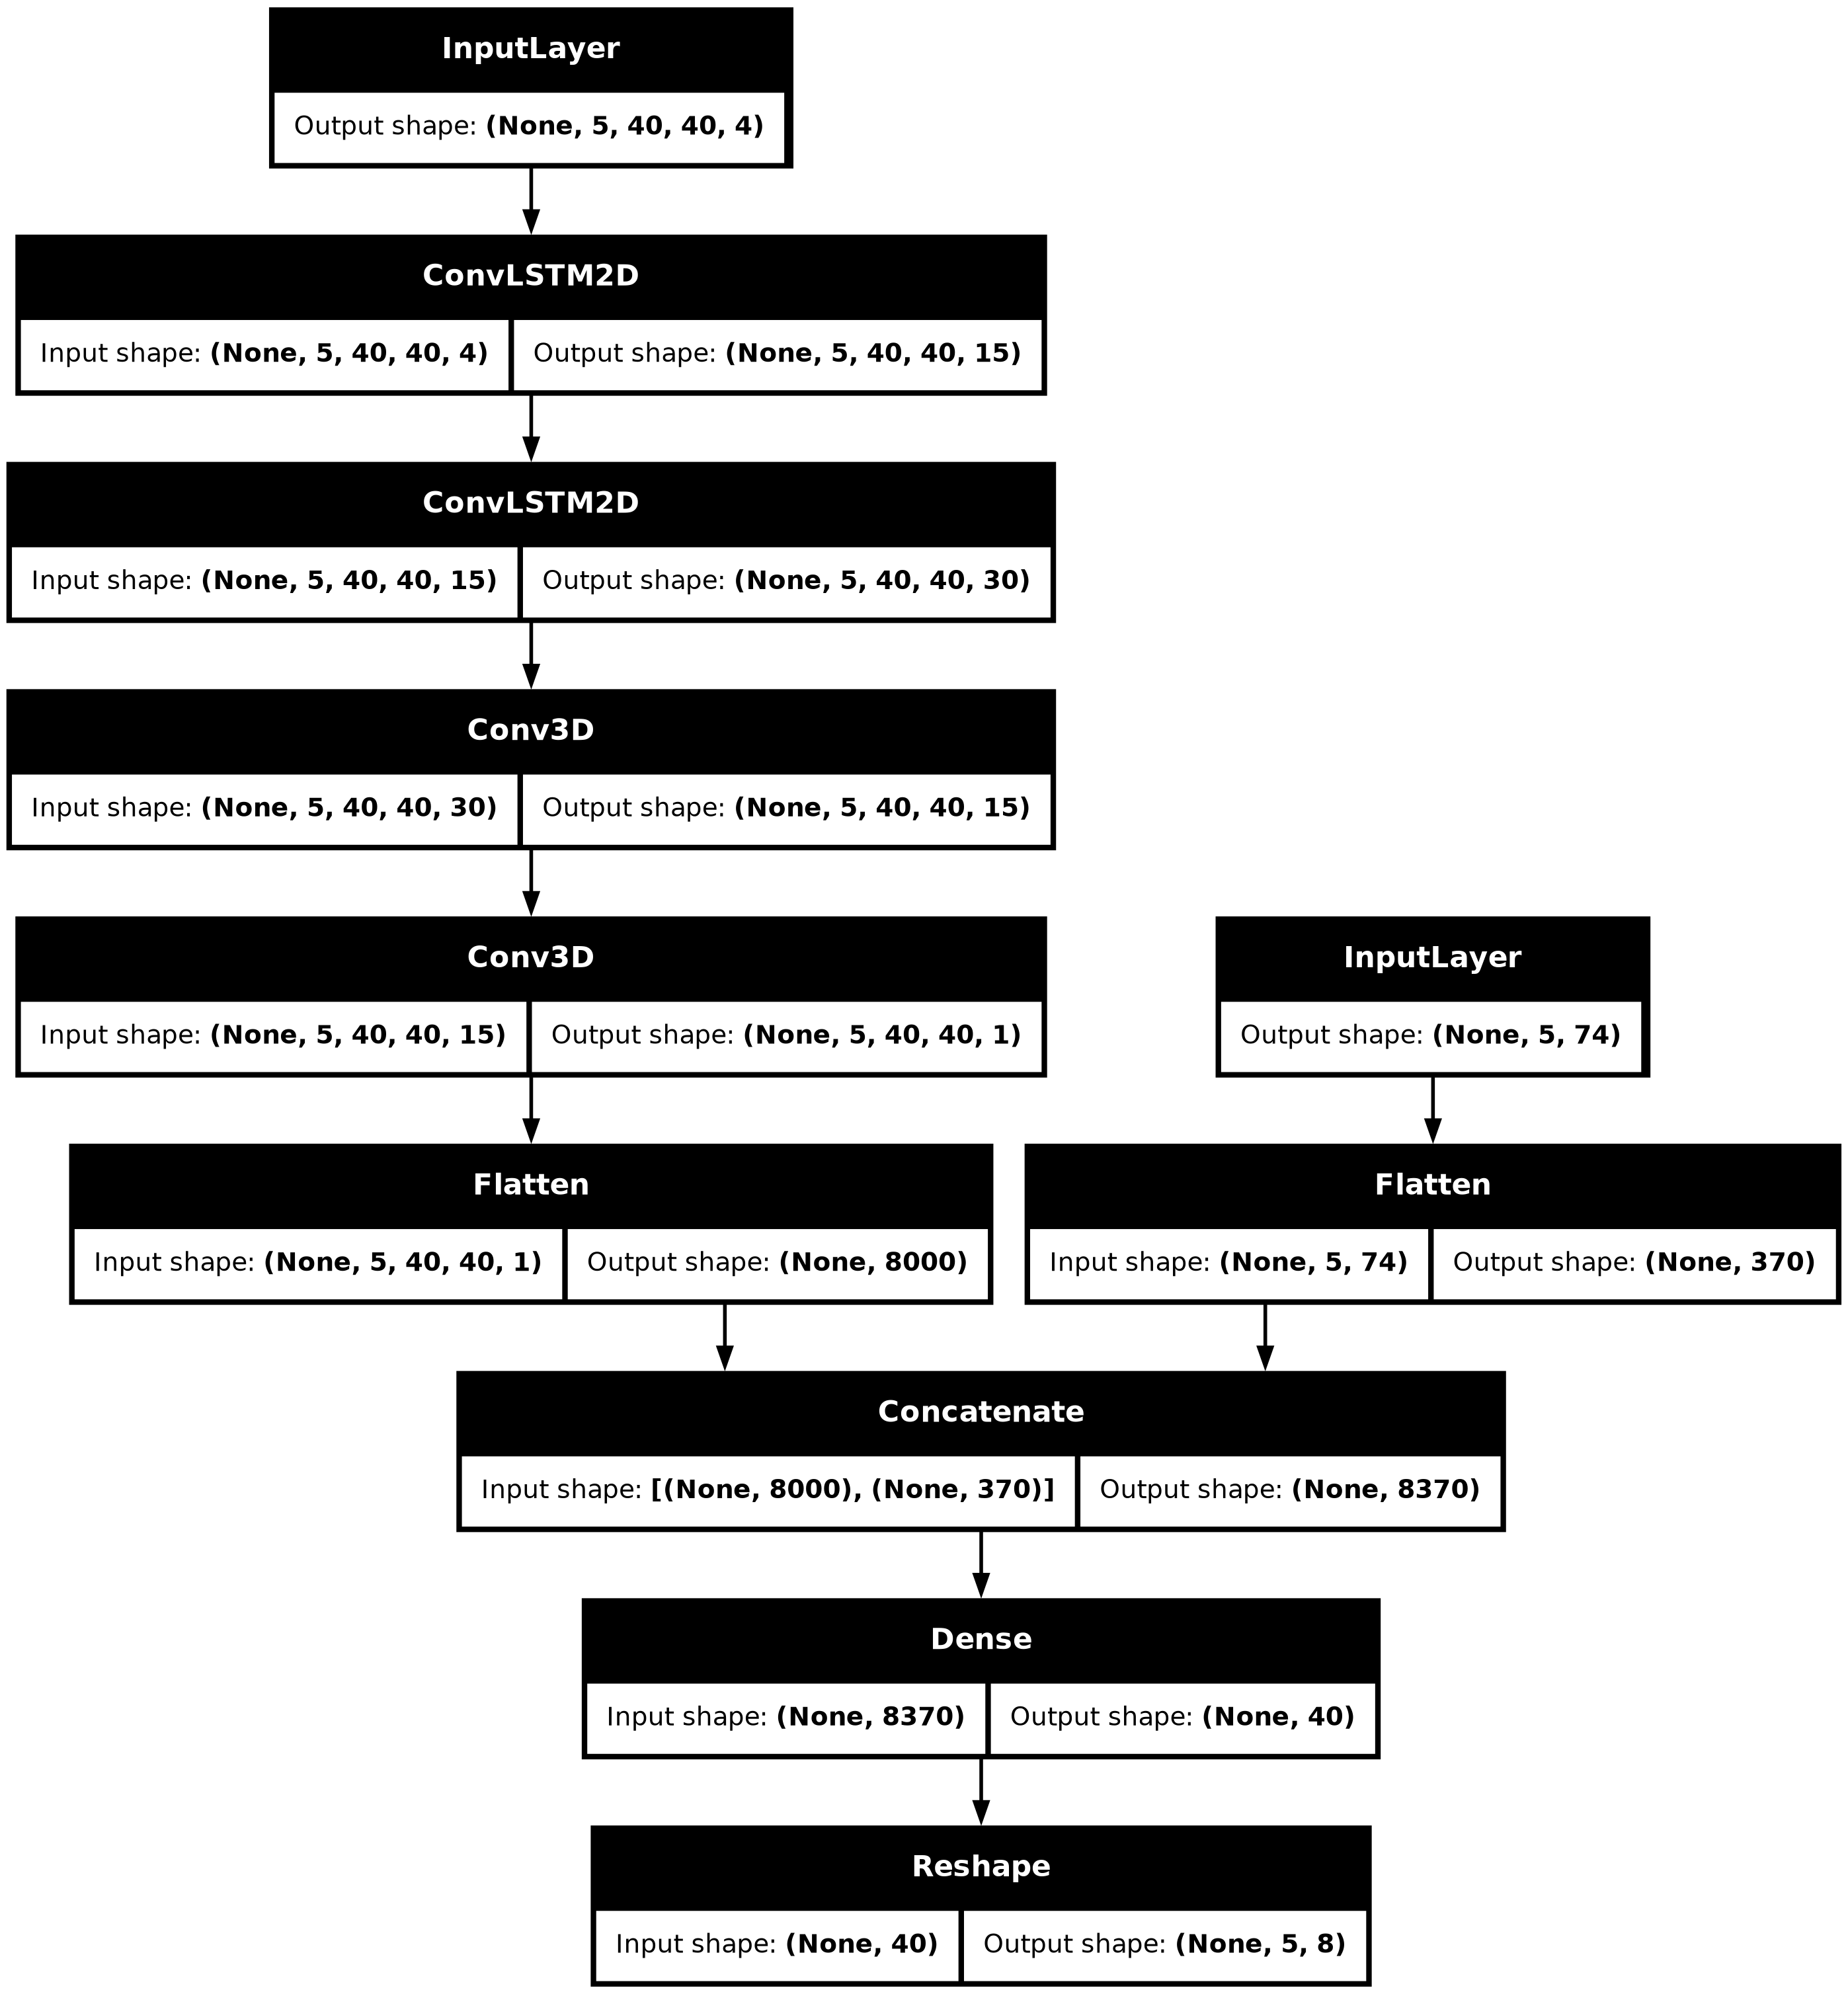

In [9]:
keras.utils.plot_model(model, "model_graph.png", show_shapes=True)

## Callbacks

In [10]:
from keras.callbacks import EarlyStopping, TensorBoard, ModelCheckpoint, ReduceLROnPlateau
import os
import time

# tensorboard gradient logging callback
# at the end of an epoch, pass in a sample batch and calculate the gradients
class GradientLogger(tf.keras.callbacks.Callback):
    def __init__(self, log_dir, data_sample):
        super().__init__()
        self.writer = tf.summary.create_file_writer(log_dir)
        self.data_sample = data_sample  # A batch of (x, y) from your training data

    def on_epoch_end(self, epoch, logs=None):
        # log gradients
        x, y = self.data_sample

        with tf.GradientTape() as tape:
            loss = self.model.compute_loss(
                y=y, 
                y_pred=self.model(x, training=True)
            )

        gradients = tape.gradient(loss, self.model.trainable_weights)
        grad_norm = tf.linalg.global_norm(gradients)

        # plot gradients
        with self.writer.as_default():
            tf.summary.scalar("gradient_norm/global", grad_norm, step=epoch)
            
            for weight, grad in zip(self.model.trainable_weights, gradients):
                if grad is not None:
                    tf.summary.histogram(f"gradients/{weight.name}", grad, step=epoch)
            self.writer.flush()

# tensorboard callback setup
def get_run_logdir(
    root_logdir, 
    run_id=time.strftime("run_%Y_%m_%d-%H_%M_%S")
):
    return os.path.join(root_logdir, run_id)
    
run_logdir = get_run_logdir(
    root_logdir=os.path.join(os.curdir, "my_logs"),
    run_id="default"
)
tensorboard_callback = TensorBoard(run_logdir, histogram_freq=1)
#gradient_logging_callback = GradientLogger(run_logdir, data_sample=(X_test_scaled[:32], Y_test[:32]))

# model checkpoint callback setup
model_checkpoint_callback = ModelCheckpoint(
    filepath=model_checkpoint_file,
    monitor='val_loss',
    mode='min',
    save_best_only=True
)

# lr scheduling callback setup
lr_scheduling_callback = ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.1,
    patience=10,
)

# early stopping callback
early_stopping_callback = EarlyStopping(
    monitor='val_loss', 
    patience=20,
    restore_best_weights=True,
)

# define list of callbacks we're gonna use
callbacks = [
    #early_stopping_callback,
    model_checkpoint_callback,
    #lr_scheduling_callback,
    #tensorboard_callback,
    #gradient_logging_callback
]

## Training

In [11]:
history = model.fit(
    x=[X_train, X_train_2],
    y=Y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=([X_valid, X_valid_2], Y_valid),
    callbacks=callbacks
)

Epoch 1/100


/home/mgraca/miniconda3/envs/hrrrenv/lib/python3.12/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor', 'keras_tensor_1']. Received: the structure of inputs=('*', '*')
  warnings.warn(
I0000 00:00:1754796376.180514   71835 service.cc:148] XLA service 0x7e5d8c0f92c0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1754796376.180538   71835 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 2070 SUPER, Compute Capability 7.5
2025-08-09 20:26:16.243811: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1754796376.515266   71835 cuda_dnn.cc:529] Loaded cuDNN version 90800
2025-08-09 20:26:16.963366: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k2

  3/384 ━━━━━━━━━━━━━━━━━━━━ 20s 54ms/step - loss: 10.5521

I0000 00:00:1754796378.955478   71835 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


383/384 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - loss: 6.1415

2025-08-09 20:26:39.888717: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=2} for conv (f32[18,30,40,40]{3,2,1,0}, u8[0]{0}) custom-call(f32[18,15,40,40]{3,2,1,0}, f32[30,15,3,3]{3,2,1,0}, f32[30]{0}, f32[18,30,40,40]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":1},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]}
2025-08-09 20:26:40.013823: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=2} for conv (f32[18,15,40,40]{3,2,1,0}, u8[0]{0}) custom-call(f32[18,4,40,40]{3,2,1,0}, f32[15,4,3,3]{3,2,1,0}, f32[15]{0}, f32[18,15,40,40]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01-

384/384 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 6.1368

2025-08-09 20:26:44.279639: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=2} for conv (f32[6,15,40,40]{3,2,1,0}, u8[0]{0}) custom-call(f32[6,4,40,40]{3,2,1,0}, f32[15,4,3,3]{3,2,1,0}, f32[15]{0}, f32[6,15,40,40]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":1},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]}
2025-08-09 20:26:44.321621: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=2} for conv (f32[6,30,40,40]{3,2,1,0}, u8[0]{0}) custom-call(f32[6,15,40,40]{3,2,1,0}, f32[30,15,3,3]{3,2,1,0}, f32[30]{0}, f32[6,30,40,40]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01,

384/384 ━━━━━━━━━━━━━━━━━━━━ 31s 67ms/step - loss: 6.1321 - val_loss: 3.6758
Epoch 2/100
384/384 ━━━━━━━━━━━━━━━━━━━━ 22s 57ms/step - loss: 3.0865 - val_loss: 3.3905
Epoch 3/100
384/384 ━━━━━━━━━━━━━━━━━━━━ 22s 57ms/step - loss: 2.8406 - val_loss: 3.2429
Epoch 4/100
384/384 ━━━━━━━━━━━━━━━━━━━━ 22s 57ms/step - loss: 2.6810 - val_loss: 3.1764
Epoch 5/100
384/384 ━━━━━━━━━━━━━━━━━━━━ 22s 57ms/step - loss: 2.6026 - val_loss: 3.0795
Epoch 6/100
384/384 ━━━━━━━━━━━━━━━━━━━━ 22s 57ms/step - loss: 2.5183 - val_loss: 2.9530
Epoch 7/100
384/384 ━━━━━━━━━━━━━━━━━━━━ 22s 57ms/step - loss: 2.4446 - val_loss: 2.8633
Epoch 8/100
384/384 ━━━━━━━━━━━━━━━━━━━━ 22s 57ms/step - loss: 2.3687 - val_loss: 2.8206
Epoch 9/100
384/384 ━━━━━━━━━━━━━━━━━━━━ 22s 57ms/step - loss: 2.3283 - val_loss: 2.7703
Epoch 10/100
384/384 ━━━━━━━━━━━━━━━━━━━━ 22s 57ms/step - loss: 2.2764 - val_loss: 2.7334
Epoch 11/100
384/384 ━━━━━━━━━━━━━━━━━━━━ 22s 57ms/step - loss: 2.2401 - val_loss: 2.7282
Epoch 12/100
384/384 ━━━━━━━━━━

# Model Evaluation


Evaluating model


2025-08-09 21:03:40.923323: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=2} for conv (f32[7,15,40,40]{3,2,1,0}, u8[0]{0}) custom-call(f32[7,4,40,40]{3,2,1,0}, f32[15,4,3,3]{3,2,1,0}, f32[15]{0}, f32[7,15,40,40]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":1},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]}
2025-08-09 21:03:40.964168: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=2} for conv (f32[7,30,40,40]{3,2,1,0}, u8[0]{0}) custom-call(f32[7,15,40,40]{3,2,1,0}, f32[30,15,3,3]{3,2,1,0}, f32[30]{0}, f32[7,30,40,40]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01,

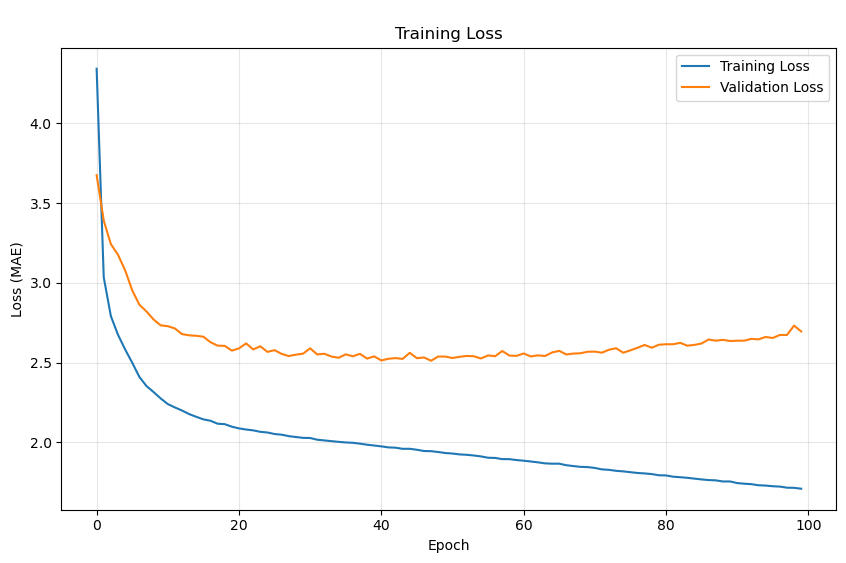

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from datetime import datetime

# Evaluate model
print(f"\nEvaluating model")
#model = keras.saving.load_model(model_checkpoint_file)
y_pred = model.predict([X_test, X_test_2], verbose=0)

# Plot training history
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title(f'\nTraining Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (MAE)')
plt.grid(True, alpha=0.3)
plt.show()

In [13]:
print(Y_test.shape, y_pred.shape)

(2631, 5, 8) (2631, 5, 8)


In [14]:
from libs.plotting import *
import pandas as pd
from sklearn.metrics import mean_absolute_percentage_error as mape

# avg error of each station across all frames
results = [
    [
        rmse(Y_test[1:], Y_test[:-1]), 
        rmse(y_pred, Y_test),
        rmse(y_pred[1:], Y_test[:-1]),
    ],
    [
        nrmse(Y_test[1:], Y_test[:-1]),
        nrmse(y_pred, Y_test),        
        nrmse(y_pred[1:], Y_test[:-1]),

    ],
    [        
        mae(Y_test[1:], Y_test[:-1]),
        mae(y_pred, Y_test),
        mae(y_pred[1:], Y_test[:-1]),
    ],
    [
        mape(Y_test[:-1].flatten(), Y_test[1:].flatten())*100,
        mape(Y_test.flatten(), y_pred.flatten())*100,
        mape(Y_test[:-1].flatten(), y_pred[1:].flatten())*100,
    ],
    [
        r2_score(Y_test[:-1], Y_test[1:]),
        r2_score(Y_test, y_pred),
        r2_score(Y_test[:-1], y_pred[1:]),
    ]
]

df = pd.DataFrame(
    results, 
    columns=['Baseline Error', 'Model Error', 'Model Error Shifted'], 
    index=['RMSE', 'NRMSE', 'MAE', 'MAPE', 'R2']
)
display(df)

,Baseline Error,Model Error,Model Error Shifted
RMSE,1.573309,2.467777,2.284083
NRMSE,15.883256,24.912001,23.058837
MAE,1.083952,1.827800,1.672670
MAPE,13.768239,25.289068,23.398602
R2,0.865896,0.669975,0.717357


In [15]:
# avg pm2.5 over the entire area vs avg prediction over entire area
# basically all stations merged into 1 value instead of average error on each particular station
# difference with above: calculate errors of each station, THEN average VS calculate average PM2.5, THEN calculate error
y_pred_avg = np.mean(y_pred, axis=-1)
Y_test_avg = np.mean(Y_test, axis=-1)

results = [
    [
        rmse(Y_test_avg[1:], Y_test_avg[:-1]), 
        rmse(y_pred_avg, Y_test_avg),
        rmse(y_pred_avg[1:], Y_test_avg[:-1]),
    ],
    [
        nrmse(Y_test_avg[1:], Y_test_avg[:-1]),
        nrmse(y_pred_avg, Y_test_avg),        
        nrmse(y_pred_avg[1:], Y_test_avg[:-1]),

    ],
    [        
        mae(Y_test_avg[1:], Y_test_avg[:-1]),
        mae(y_pred_avg, Y_test_avg),
        mae(y_pred_avg[1:], Y_test_avg[:-1]),
    ],
    [
        mape(Y_test_avg[:-1].flatten(), Y_test_avg[1:].flatten())*100,
        mape(Y_test_avg.flatten(), y_pred_avg.flatten())*100,
        mape(Y_test_avg[:-1].flatten(), y_pred_avg[1:].flatten())*100,
    ],
    [
        r2_score(Y_test_avg[:-1], Y_test_avg[1:]),
        r2_score(Y_test_avg, y_pred_avg),
        r2_score(Y_test_avg[:-1], y_pred_avg[1:]),
    ]
]

df = pd.DataFrame(
    results, 
    columns=['Baseline Error', 'Model Error', 'Model Error Shifted'], 
    index=['RMSE', 'NRMSE', 'MAE', 'MAPE', 'R2']
)
display(df)

,Baseline Error,Model Error,Model Error Shifted
RMSE,0.788532,1.295141,1.195927
NRMSE,7.960584,13.074341,12.073419
MAE,0.529188,0.909634,0.847260
MAPE,5.700648,10.683794,9.949912
R2,0.943561,0.847698,0.870177


In [16]:
# first-frame error
results = [
    [
        rmse(Y_test[1:, 0], Y_test[:-1, 0]), 
        rmse(y_pred[:, 0], Y_test[:, 0]),
        rmse(y_pred[1:, 0], Y_test[:-1, 0]),
    ],
    [
        nrmse(Y_test[1:, 0], Y_test[:-1, 0]),
        nrmse(y_pred[:, 0], Y_test[:, 0]),        
        nrmse(y_pred[1:, 0], Y_test[:-1, 0]),

    ],
    [        
        mae(Y_test[1:, 0], Y_test[:-1, 0]),
        mae(y_pred[:, 0], Y_test[:, 0]),
        mae(y_pred[1:, 0], Y_test[:-1, 0]),
    ],
    [
        mape(np.squeeze(Y_test[:-1, 0]), np.squeeze(Y_test[1:, 0]))*100,
        mape(np.squeeze(Y_test[:, 0]), np.squeeze(y_pred[:, 0]))*100,
        mape(np.squeeze(Y_test[:-1, 0]), np.squeeze(y_pred[1:, 0]))*100,
    ],
    [
        r2_score(Y_test[:-1, 0], Y_test[1:, 0]),
        r2_score(Y_test[:, 0], y_pred[:, 0]),
        r2_score(Y_test[:-1, 0], y_pred[1:, 0]),
    ]
]

df = pd.DataFrame(
    results, 
    columns=['Baseline Error', 'Model Error', 'Model Error Shifted'], 
    index=['RMSE', 'NRMSE', 'MAE', 'MAPE', 'R2']
)
display(df)

,Baseline Error,Model Error,Model Error Shifted
RMSE,1.573352,1.613696,1.106191
NRMSE,15.881344,16.287471,11.165843
MAE,1.083828,1.164172,0.853712
MAPE,13.766298,15.617749,12.094132
R2,0.865971,0.858975,0.933747


In [17]:
# first frame LA error
results = [
    [
        rmse(Y_test[1:, 0, 4], Y_test[:-1, 0, 4]), 
        rmse(y_pred[:, 0, 4], Y_test[:, 0, 4]),
        rmse(y_pred[1:, 0, 4], Y_test[:-1, 0, 4]),
    ],
    [
        nrmse(Y_test[1:, 0, 4], Y_test[:-1, 0, 4]),
        nrmse(y_pred[:, 0, 4], Y_test[:, 0, 4]),        
        nrmse(y_pred[1:, 0, 4], Y_test[:-1, 0, 4]),

    ],
    [        
        mae(Y_test[1:, 0, 4], Y_test[:-1, 0, 4]),
        mae(y_pred[:, 0, 4], Y_test[:, 0, 4]),
        mae(y_pred[1:, 0, 4], Y_test[:-1, 0, 4]),
    ],
    [
        mape(np.squeeze(Y_test[:-1, 0, 4]), np.squeeze(Y_test[1:, 0, 4]))*100,
        mape(np.squeeze(Y_test[:, 0, 4]), np.squeeze(y_pred[:, 0, 4]))*100,
        mape(np.squeeze(Y_test[:-1, 0, 4]), np.squeeze(y_pred[1:, 0, 4]))*100,
    ],
    [
        r2_score(Y_test[:-1, 0, 4], Y_test[1:, 0, 4]),
        r2_score(Y_test[:, 0, 4], y_pred[:, 0, 4]),
        r2_score(Y_test[:-1, 0, 4], y_pred[1:, 0, 4]),
    ]
]

df = pd.DataFrame(
    results, 
    columns=['Baseline Error', 'Model Error', 'Model Error Shifted'], 
    index=['RMSE', 'NRMSE', 'MAE', 'MAPE', 'R2']
)
display(df)

,Baseline Error,Model Error,Model Error Shifted
RMSE,1.655120,1.712479,1.284292
NRMSE,14.034266,14.519832,10.889904
MAE,1.094682,1.264100,1.001936
MAPE,10.432978,13.577284,11.205882
R2,0.892911,0.885321,0.935522


In [18]:
# first frame, error breakdown for every sensor, nrmse
results = [
    *[
        [
            nrmse(Y_test[1:, 0, i], Y_test[:-1, 0, i]),
            nrmse(y_pred[:, 0, i], Y_test[:, 0, i]),
            nrmse(y_pred[1:, 0, i], Y_test[:-1, 0, i])
        ]
        for i in range(len(sensor_names))
    ]
]
df = pd.DataFrame(
    results, 
    columns=['Baseline NRMSE', 'Model NRMSE', 'Model NRMSE Shifted'], 
    index=sensor_names
)
display(df)

,Baseline NRMSE,Model NRMSE,Model NRMSE Shifted
Simi Valley - Cochran Street,15.005320,17.707590,12.775918
Reseda,17.485002,17.362577,12.296355
Santa Clarita,14.758760,14.629219,8.812500
North Holywood,15.149515,14.450302,10.446517
Los Angeles - N. Main Street,14.034266,14.519832,10.889904
Compton,14.630370,15.182520,10.350179
Long Beach Signal Hill,21.038773,22.094134,13.550087
Anaheim,15.546726,15.623238,10.717234


📊 TEMPORAL DEGRADATION ANALYSIS
This measures how ConvLSTM prediction accuracy degrades as we predict further into the future.
Later time steps are inherently harder to predict due to error accumulation.



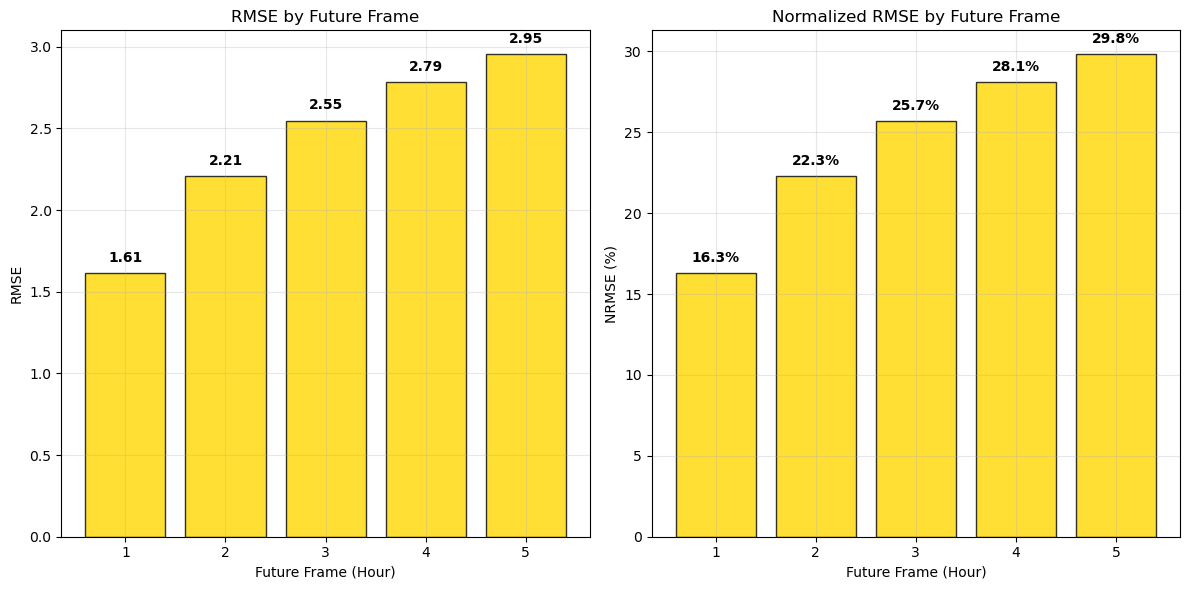


📊 FRAME-BY-FRAME RMSE SUMMARY:
Hour 1: RMSE = 1.614 (16.3%)
Hour 2: RMSE = 2.209 (22.3%)
Hour 3: RMSE = 2.548 (25.7%)
Hour 4: RMSE = 2.785 (28.1%)
Hour 5: RMSE = 2.952 (29.8%)
📋 DETAILED CONVLSTM PERFORMANCE BREAKDOWN
This section provides comprehensive metrics for each prediction horizon and monitoring station.
Essential for identifying specific model weaknesses and guiding improvements.

📋 DETAILED FRAME-BY-FRAME STATISTICS

🕐 HOUR 1 ANALYSIS
────────────────────────────────────────────────────────────────────────────────────────────────────
┌─ OVERALL PERFORMANCE ──────────────────────────────────────────────────────────┐
│ RMSE:  1.614 (16.3%)   │   MAE:  1.164   │   R²:  0.859              │
└────────────────────────────────────────────────────────────────────────────────┘

📍 BY SENSOR LOCATION:
────────────────────────────────────────────────────────────────────────────────────────────────────
Location                 │RMSE   │%     │MAE    │R²     │Actual │Pred  
──────────────

In [19]:
plot_frame_by_frame_rmse(y_pred, Y_test)
print_detailed_frame_stats(y_pred, Y_test, sensor_names)

📊 TEMPORAL DEGRADATION ANALYSIS
This measures how ConvLSTM prediction accuracy degrades as we predict further into the future.
Later time steps are inherently harder to predict due to error accumulation.



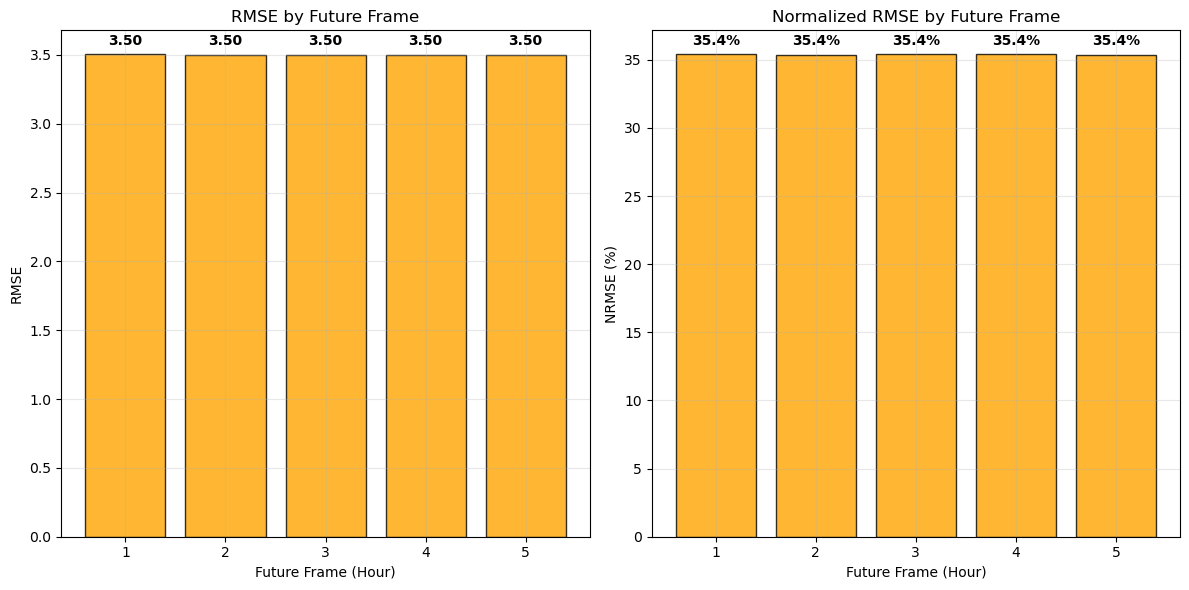


📊 FRAME-BY-FRAME RMSE SUMMARY:
Hour 1: RMSE = 3.503 (35.4%)
Hour 2: RMSE = 3.503 (35.4%)
Hour 3: RMSE = 3.503 (35.4%)
Hour 4: RMSE = 3.502 (35.4%)
Hour 5: RMSE = 3.501 (35.4%)
📋 DETAILED CONVLSTM PERFORMANCE BREAKDOWN
This section provides comprehensive metrics for each prediction horizon and monitoring station.
Essential for identifying specific model weaknesses and guiding improvements.

📋 DETAILED FRAME-BY-FRAME STATISTICS

🕐 HOUR 1 ANALYSIS
────────────────────────────────────────────────────────────────────────────────────────────────────
┌─ OVERALL PERFORMANCE ──────────────────────────────────────────────────────────┐
│ RMSE:  3.503 (35.4%)   │   MAE:  2.621   │   R²:  0.335              │
└────────────────────────────────────────────────────────────────────────────────┘

📍 BY SENSOR LOCATION:
────────────────────────────────────────────────────────────────────────────────────────────────────
Location                 │RMSE   │%     │MAE    │R²     │Actual │Pred  
──────────────

In [20]:
# new baseline; copy last 5 frames to predict next 5 frames
plot_frame_by_frame_rmse(Y_test[:-5], Y_test[5:])
print_detailed_frame_stats(Y_test[:-5], Y_test[5:], sensor_names)

📊 TEMPORAL DEGRADATION ANALYSIS
This measures how ConvLSTM prediction accuracy degrades as we predict further into the future.
Later time steps are inherently harder to predict due to error accumulation.



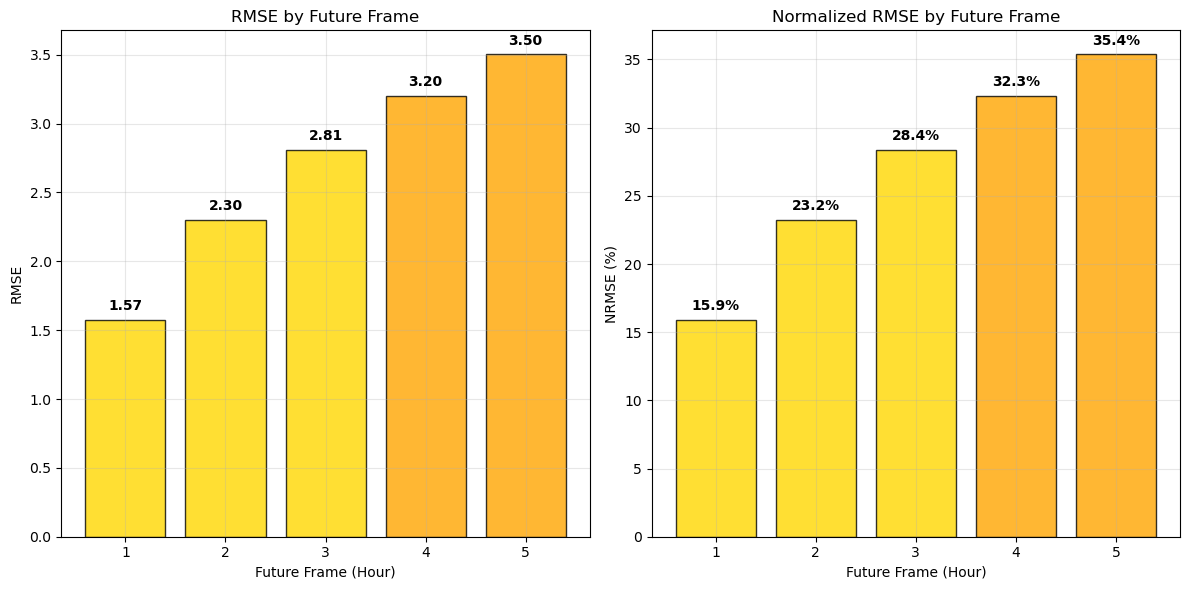


📊 FRAME-BY-FRAME RMSE SUMMARY:
Hour 1: RMSE = 1.573 (15.9%)
Hour 2: RMSE = 2.299 (23.2%)
Hour 3: RMSE = 2.808 (28.4%)
Hour 4: RMSE = 3.200 (32.3%)
Hour 5: RMSE = 3.502 (35.4%)
📋 DETAILED CONVLSTM PERFORMANCE BREAKDOWN
This section provides comprehensive metrics for each prediction horizon and monitoring station.
Essential for identifying specific model weaknesses and guiding improvements.

📋 DETAILED FRAME-BY-FRAME STATISTICS

🕐 HOUR 1 ANALYSIS
────────────────────────────────────────────────────────────────────────────────────────────────────
┌─ OVERALL PERFORMANCE ──────────────────────────────────────────────────────────┐
│ RMSE:  1.573 (15.9%)   │   MAE:  1.084   │   R²:  0.866              │
└────────────────────────────────────────────────────────────────────────────────┘

📍 BY SENSOR LOCATION:
────────────────────────────────────────────────────────────────────────────────────────────────────
Location                 │RMSE   │%     │MAE    │R²     │Actual │Pred  
──────────────

In [21]:
# new baseline; copy last 1 frames to predict next 5 frames
Y_test_copied_first_frame = np.broadcast_to(Y_test[:, 0, :][:, np.newaxis, :], Y_test.shape).copy()
plot_frame_by_frame_rmse(Y_test_copied_first_frame[:-1], Y_test[1:])
print_detailed_frame_stats(Y_test_copied_first_frame[:-1], Y_test[1:], sensor_names)

# Plots

## Snapshot plots - first frame

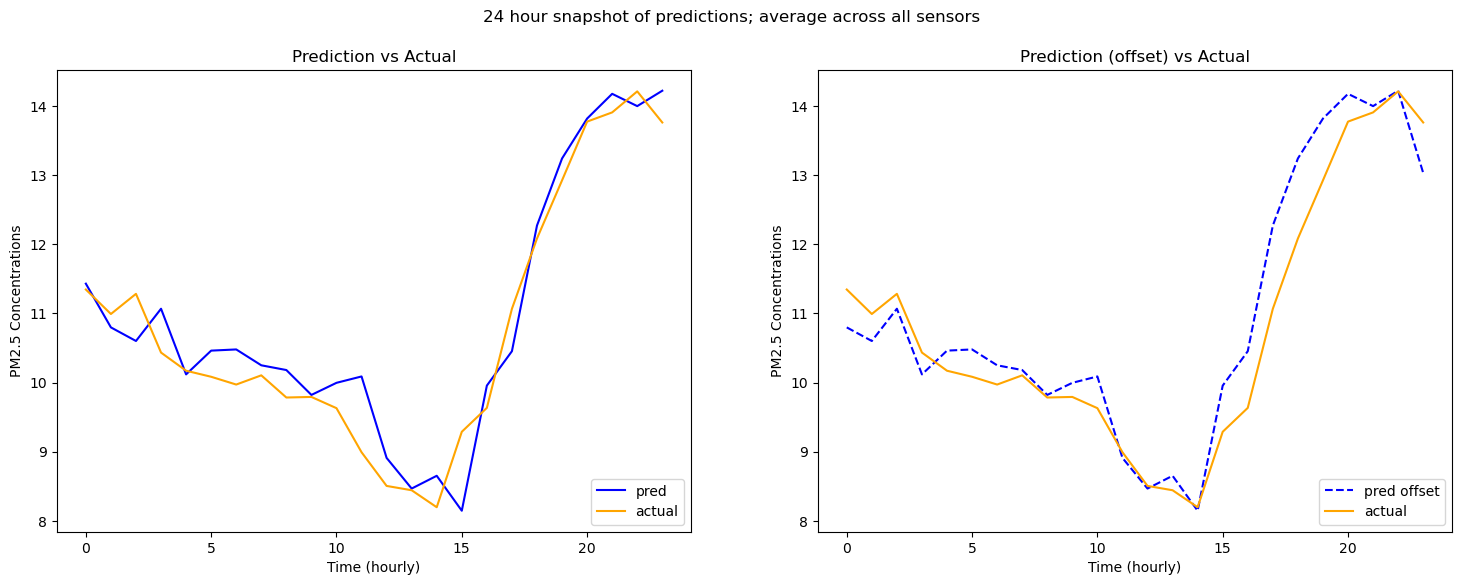

In [22]:
fig, axes = plt.subplots(1, 2, figsize=(18, 6))
fig.suptitle("24 hour snapshot of predictions; average across all sensors")

axes[0].plot(y_pred_avg[1000:1024, 0], color='blue', label='pred')
axes[0].plot(Y_test_avg[1000:1024, 0], color='orange', label='actual')
axes[0].set_xlabel("Time (hourly)")
axes[0].set_ylabel("PM2.5 Concentrations")
axes[0].legend(loc="lower right")
axes[0].set_title("Prediction vs Actual")

axes[1].plot(y_pred_avg[1001:1025, 0], color='blue', linestyle='--', label='pred offset')
axes[1].plot(Y_test_avg[1000:1024, 0], color='orange', label='actual')
axes[1].set_xlabel("Time (hourly)")
axes[1].set_ylabel("PM2.5 Concentrations")
axes[1].legend(loc="lower right")
axes[1].set_title("Prediction (offset) vs Actual")

plt.show()

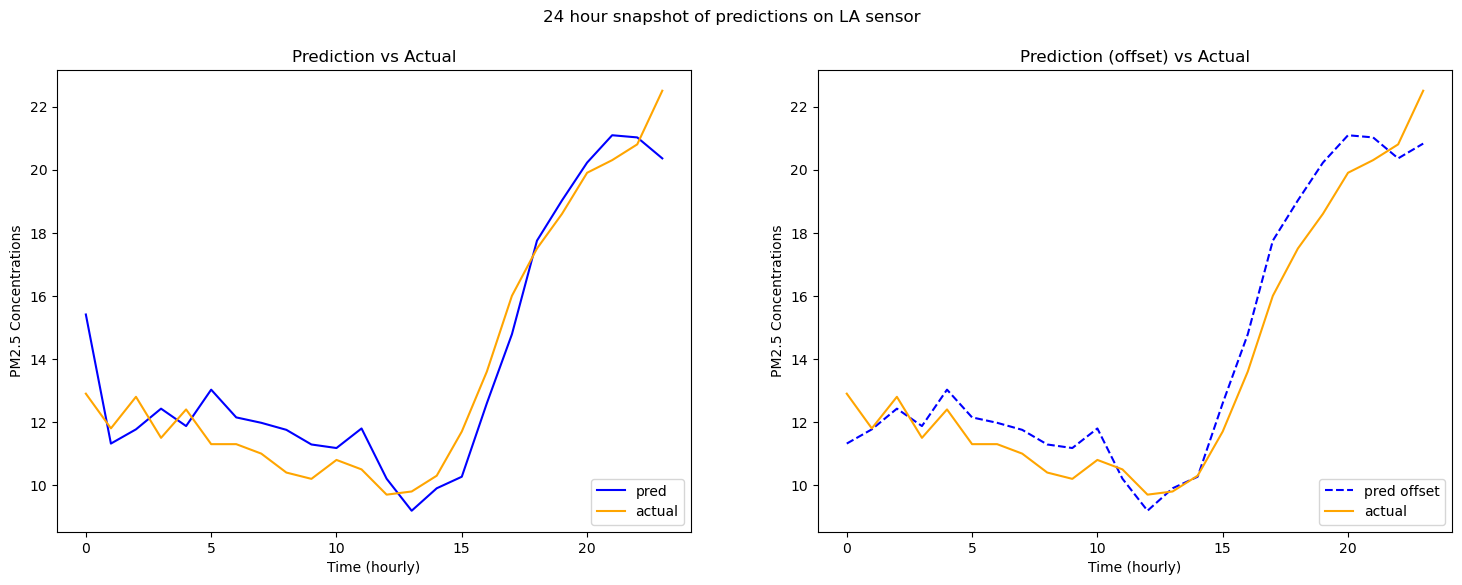

In [23]:
fig, axes = plt.subplots(1, 2, figsize=(18, 6))
fig.suptitle("24 hour snapshot of predictions on LA sensor")

axes[0].plot(y_pred[1000:1024, 0, 4], color='blue', label='pred')
axes[0].plot(Y_test[1000:1024, 0, 4], color='orange', label='actual')
axes[0].set_xlabel("Time (hourly)")
axes[0].set_ylabel("PM2.5 Concentrations")
axes[0].legend(loc="lower right")
axes[0].set_title("Prediction vs Actual")

axes[1].plot(y_pred[1001:1025, 0, 4], color='blue', linestyle='--', label='pred offset')
axes[1].plot(Y_test[1000:1024, 0, 4], color='orange', label='actual')
axes[1].set_xlabel("Time (hourly)")
axes[1].set_ylabel("PM2.5 Concentrations")
axes[1].legend(loc="lower right")
axes[1].set_title("Prediction (offset) vs Actual")

plt.show()

[]

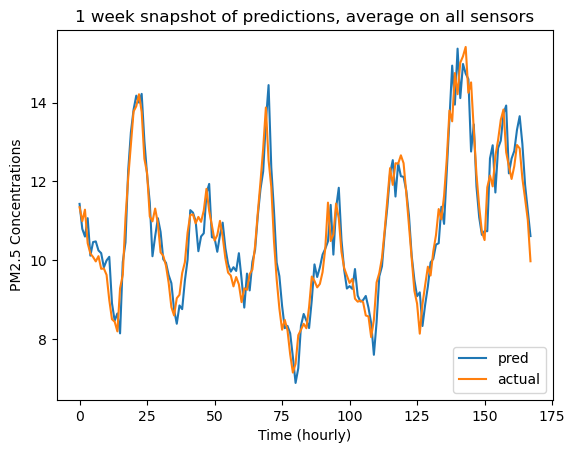

In [24]:
plt.plot(y_pred_avg[1000:1168, 0], label='pred')
plt.plot(Y_test_avg[1000:1168, 0], label='actual')
plt.xlabel("Time (hourly)")
plt.ylabel("PM2.5 Concentrations")
plt.title("1 week snapshot of predictions, average on all sensors")
plt.legend(loc="lower right")
plt.plot()

[]

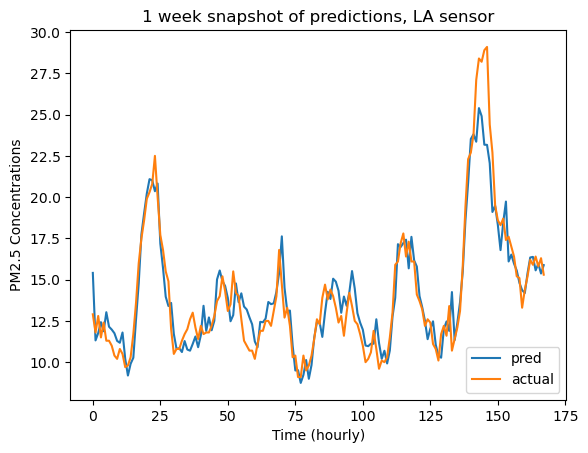

In [25]:
plt.plot(y_pred[1000:1168, 0, 4], label='pred')
plt.plot(Y_test[1000:1168, 0, 4], label='actual')
plt.xlabel("Time (hourly)")
plt.ylabel("PM2.5 Concentrations")
plt.title("1 week snapshot of predictions, LA sensor")
plt.legend(loc="lower right")
plt.plot()

In [26]:
# best/worst if all stations are averaged into one
best_week = float('inf')
worst_week = float('-inf')
best_idx, worst_idx = 0, 0

for i in range(len(y_pred) - 168):
    err = nrmse(y_pred_avg[i:i+168, 0], Y_test_avg[i:i+168, 0])
    if err < best_week:
        best_week = err
        best_idx = i
    if err > worst_week:
        worst_week = err
        worst_idx = i
print(best_idx, worst_idx)

1527 1819


In [27]:
dates = pd.date_range(START_DATE, END_DATE, freq='h')
y_test_start_idx = len(Y_valid)
y_test_end_idx = len(Y_valid) + len(Y_test)
print(dates[y_test_start_idx], dates[y_test_end_idx])

2024-03-19 14:00:00 2024-07-07 05:00:00


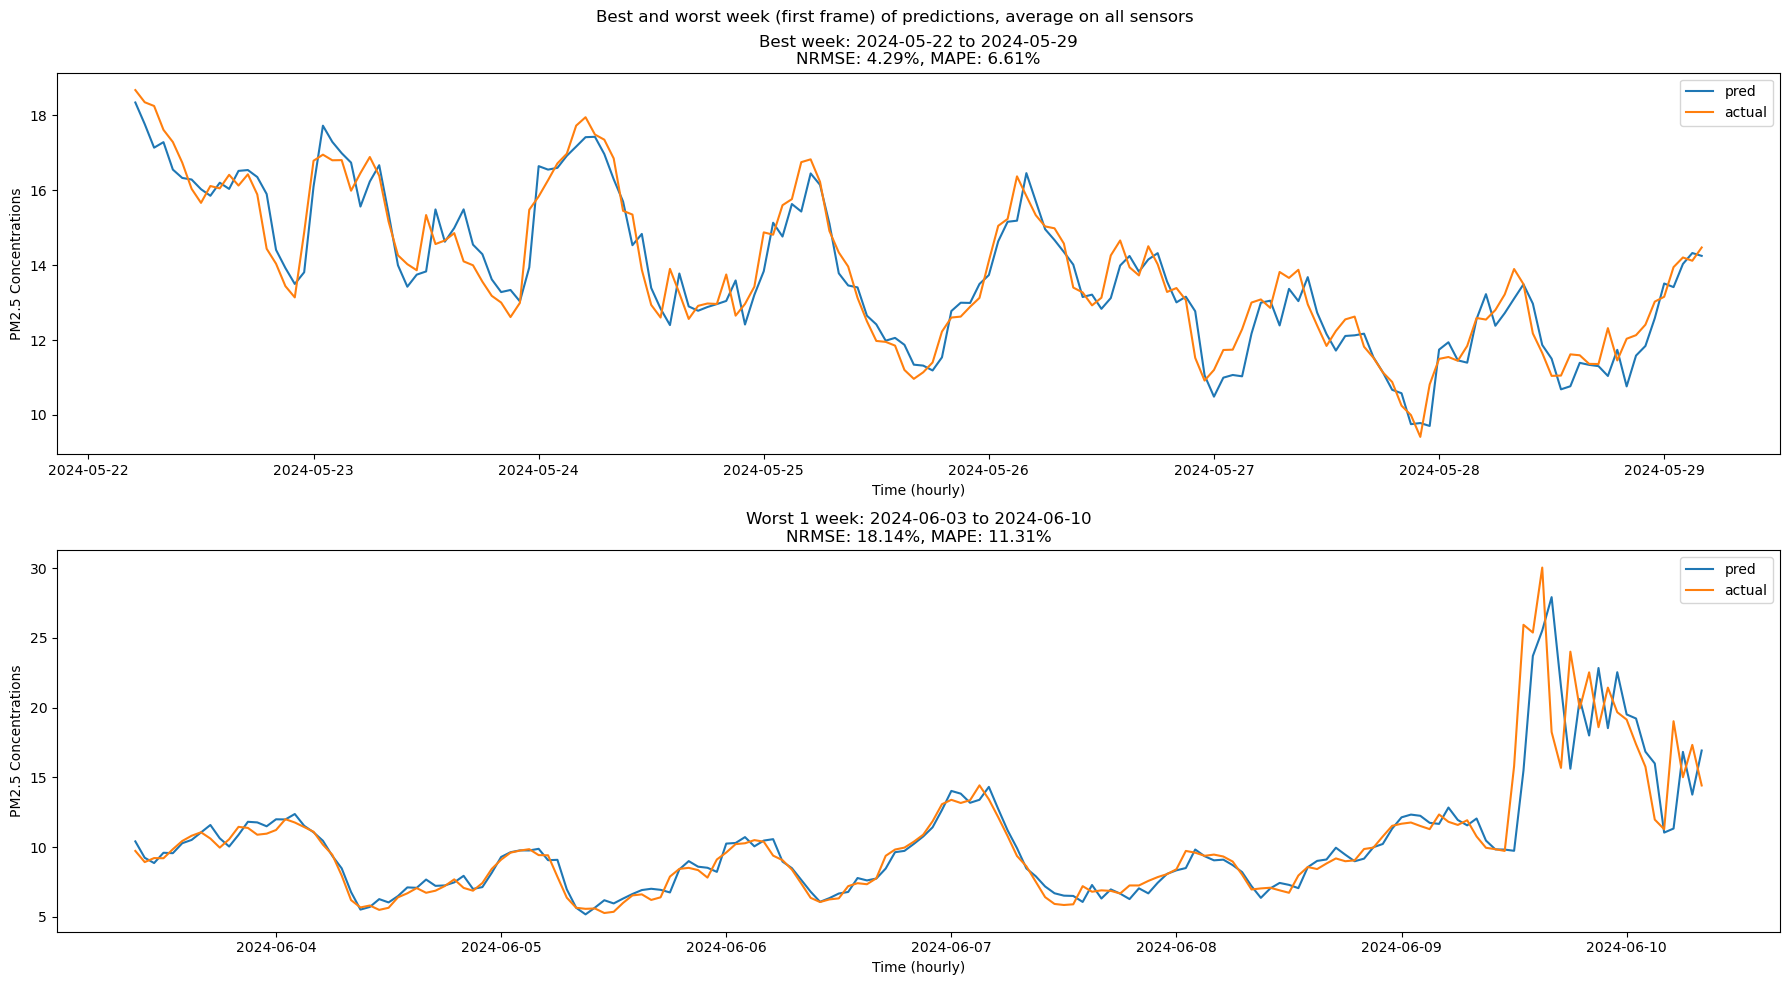

In [28]:
fig, axes = plt.subplots(2, 1, figsize=(18, 10))
fig.suptitle('Best and worst week (first frame) of predictions, average on all sensors')

# best week
axes[0].plot(
    dates[y_test_start_idx + best_idx : y_test_start_idx + best_idx + 168],
    y_pred_avg[best_idx:best_idx+168, 0],
    label='pred'
)
axes[0].plot(
    dates[y_test_start_idx + best_idx : y_test_start_idx + best_idx + 168],
    Y_test_avg[best_idx:best_idx+168, 0],
    label='actual'
)
axes[0].set_xlabel("Time (hourly)")
axes[0].set_ylabel("PM2.5 Concentrations")
axes[0].set_title(
    f"Best week: {dates[y_test_start_idx + best_idx].strftime('%Y-%m-%d')} to "
    f"{dates[y_test_start_idx + best_idx + 168].strftime('%Y-%m-%d')}\n"
    f"NRMSE: {best_week:.2f}%, "
    f"MAPE: {mape(
        np.squeeze(Y_test_avg[best_idx : best_idx + 168]), 
        np.squeeze(y_pred_avg[best_idx : best_idx + 168])
    )*100:.2f}%"
)
axes[0].legend(loc="upper right")

# worst week
axes[1].plot(
    dates[y_test_start_idx + worst_idx : y_test_start_idx + worst_idx + 168],
    y_pred_avg[worst_idx:worst_idx+168, 0], 
    label='pred'
)
axes[1].plot(
    dates[y_test_start_idx + worst_idx : y_test_start_idx + worst_idx + 168],
    Y_test_avg[worst_idx:worst_idx+168, 0],
    label='actual'
)
axes[1].set_xlabel("Time (hourly)")
axes[1].set_ylabel("PM2.5 Concentrations")
axes[1].set_title(
    f"Worst 1 week: {dates[y_test_start_idx + worst_idx].strftime('%Y-%m-%d')} to "
    f"{dates[y_test_start_idx + worst_idx + 168].strftime('%Y-%m-%d')}\n"
    f"NRMSE: {worst_week:.2f}%, "
    f"MAPE: {mape(
        np.squeeze(Y_test_avg[worst_idx : worst_idx + 168]), 
        np.squeeze(y_pred_avg[worst_idx : worst_idx + 168])
    )*100:.2f}%"
)
axes[1].legend(loc="upper right")

plt.tight_layout()
plt.show()

In [29]:
# best/worst of an individual sensor
best_week_sensor = float('inf')
worst_week_sensor = float('-inf')
best_sensor, worst_sensor = -1, -1
best_idx_sensor, worst_idx_sensor = 0, 0
for i in range(len(y_pred) - 168):
    for j in range(len(sensor_names)):
        err = nrmse(y_pred[i:i+168, 0, j], Y_test[i:i+168, 0, j])
        if err < best_week_sensor:
            best_week_sensor = err
            best_idx_sensor = i
            best_sensor = j
        if err > worst_week_sensor:
            worst_week_sensor = err
            worst_idx_sensor = i
            worst_sensor = j
print(best_idx_sensor, best_sensor, worst_idx_sensor, worst_sensor)

1402 4 2336 6


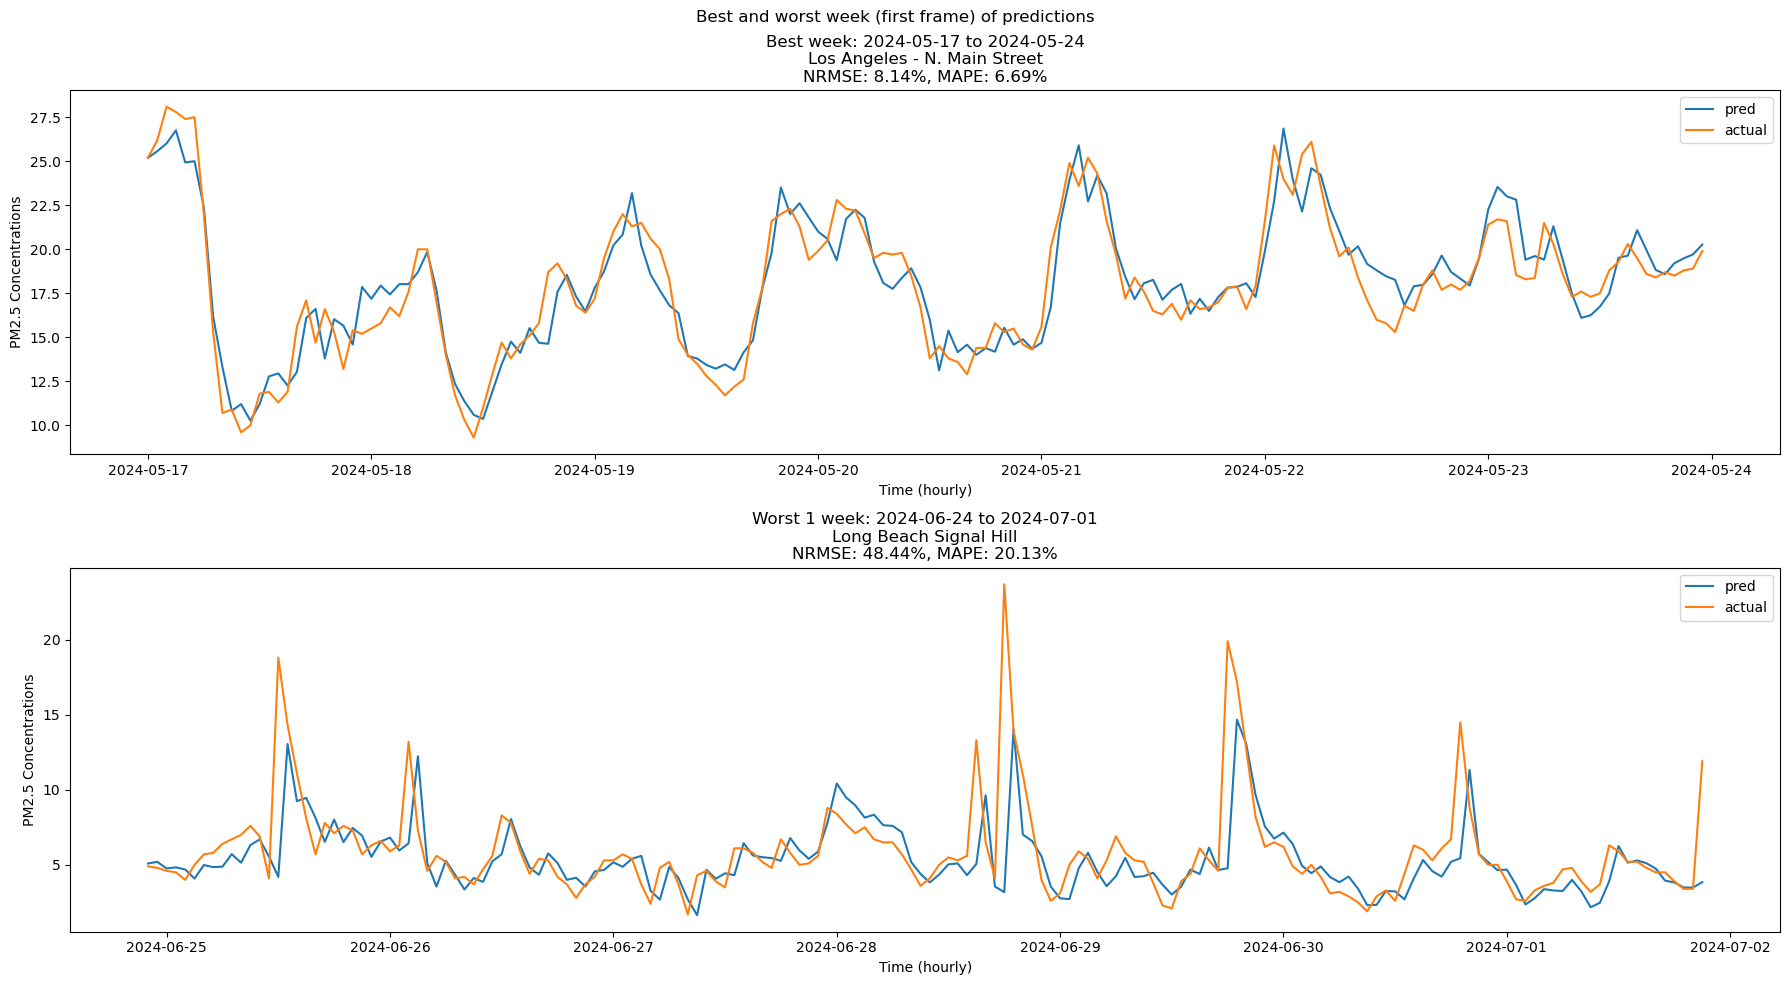

In [30]:
fig, axes = plt.subplots(2, 1, figsize=(18, 10))
fig.suptitle('Best and worst week (first frame) of predictions')

# best week
axes[0].plot(
    dates[y_test_start_idx + best_idx_sensor : y_test_start_idx + best_idx_sensor + 168],
    y_pred[best_idx_sensor:best_idx_sensor+168, 0, best_sensor],
    label='pred'
)
axes[0].plot(
    dates[y_test_start_idx + best_idx_sensor : y_test_start_idx + best_idx_sensor + 168],
    Y_test[best_idx_sensor:best_idx_sensor+168, 0, best_sensor],
    label='actual'
)
axes[0].set_xlabel("Time (hourly)")
axes[0].set_ylabel("PM2.5 Concentrations")
axes[0].set_title(
    f"Best week: {dates[y_test_start_idx + best_idx_sensor].strftime('%Y-%m-%d')} to "
    f"{dates[y_test_start_idx + best_idx_sensor + 168].strftime('%Y-%m-%d')}\n"
    f"{sensor_names[best_sensor]}\n"
    f"NRMSE: {best_week_sensor:.2f}%, "
    f"MAPE: {mape(
        np.squeeze(Y_test[best_idx_sensor : best_idx_sensor + 168, 0, best_sensor]), 
        np.squeeze(y_pred[best_idx_sensor : best_idx_sensor + 168, 0, best_sensor])
    )*100:.2f}%"
)
axes[0].legend(loc="upper right")

# worst week
axes[1].plot(
    dates[y_test_start_idx + worst_idx_sensor : y_test_start_idx + worst_idx_sensor + 168],
    y_pred[worst_idx_sensor:worst_idx_sensor+168, 0, worst_sensor], 
    label='pred'
)
axes[1].plot(
    dates[y_test_start_idx + worst_idx_sensor : y_test_start_idx + worst_idx_sensor + 168],
    Y_test[worst_idx_sensor:worst_idx_sensor+168, 0, worst_sensor],
    label='actual'
)
axes[1].set_xlabel("Time (hourly)")
axes[1].set_ylabel("PM2.5 Concentrations")
axes[1].set_title(
    f"Worst 1 week: {dates[y_test_start_idx + worst_idx_sensor].strftime('%Y-%m-%d')} to "
    f"{dates[y_test_start_idx + worst_idx_sensor + 168].strftime('%Y-%m-%d')}\n"
    f"{sensor_names[worst_sensor]}\n"
    f"NRMSE: {worst_week_sensor:.2f}%, "
    f"MAPE: {mape(
        np.squeeze(Y_test[worst_idx_sensor : worst_idx_sensor + 168, 0, worst_sensor]), 
        np.squeeze(y_pred[worst_idx_sensor: worst_idx_sensor + 168, 0, worst_sensor])
    )*100:.2f}%"
)
axes[1].legend(loc="upper right")

plt.tight_layout()
plt.show()

## Rolling avg plots

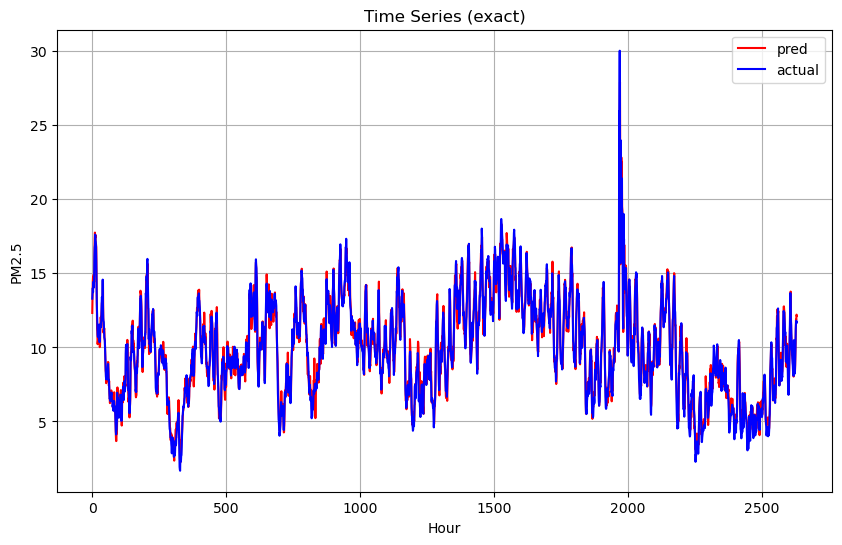

In [31]:
series_pred = pd.Series(np.squeeze(y_pred_avg[:, 0]))
series_test = pd.Series(np.squeeze(Y_test_avg[:, 0]))

plt.figure(figsize=(10, 6))
plt.plot(series_pred, label=f'pred', color='red')
plt.plot(series_test, label=f'actual', color='blue')
plt.title('Time Series (exact)')
plt.xlabel('Hour')
plt.ylabel('PM2.5')
plt.legend()
plt.grid(True)
plt.show()

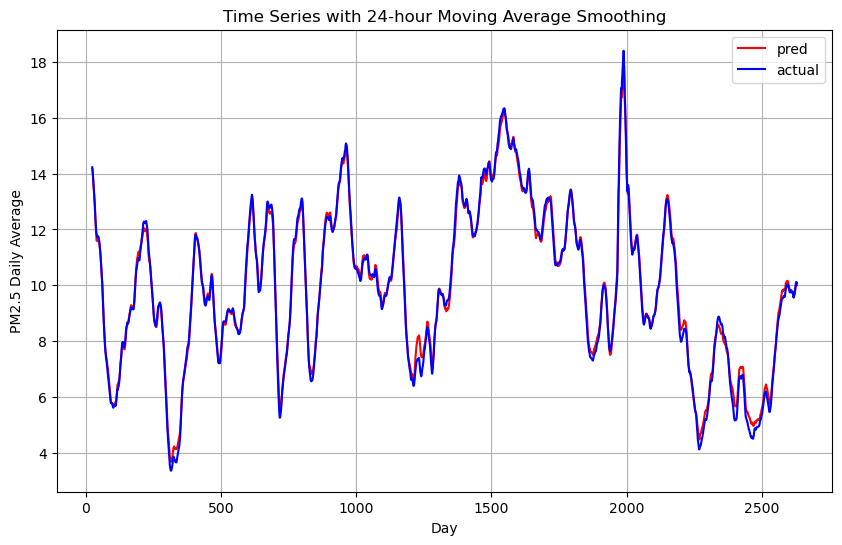

In [32]:
import pandas as pd

window_size = 24 # daily average
smoothed_pred = series_pred.rolling(window=window_size).mean()
smoothed_test = series_test.rolling(window=window_size).mean()

plt.figure(figsize=(10, 6))
plt.plot(smoothed_pred, label=f'pred', color='red')
plt.plot(smoothed_test, label=f'actual', color='blue')
plt.title('Time Series with 24-hour Moving Average Smoothing')
plt.xlabel('Day')
plt.ylabel('PM2.5 Daily Average')
plt.legend()
plt.grid(True)
plt.show()

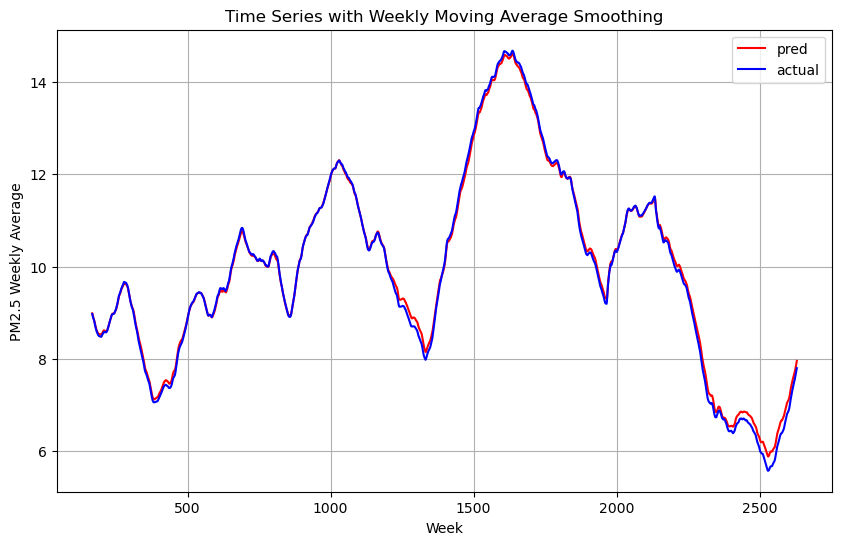

In [33]:
window_size = 168 # weekly average
smoothed_pred = series_pred.rolling(window=window_size).mean()
smoothed_test = series_test.rolling(window=window_size).mean()

plt.figure(figsize=(10, 6))
plt.plot(smoothed_pred, label=f'pred', color='red')
plt.plot(smoothed_test, label=f'actual', color='blue')
plt.title('Time Series with Weekly Moving Average Smoothing')
plt.xlabel('Week')
plt.ylabel('PM2.5 Weekly Average')
plt.legend()
plt.grid(True)
plt.show()

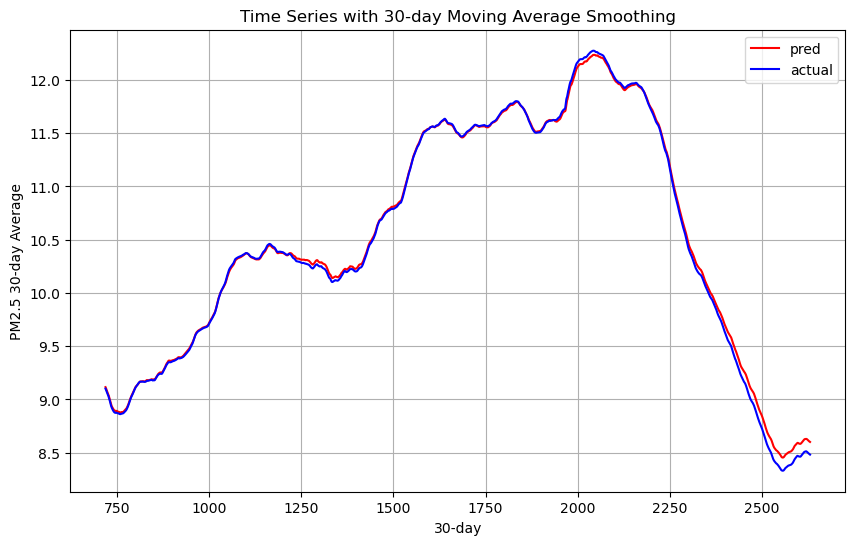

In [34]:
window_size = 720 # weekly average
smoothed_pred = series_pred.rolling(window=window_size).mean()
smoothed_test = series_test.rolling(window=window_size).mean()

plt.figure(figsize=(10, 6))
plt.plot(smoothed_pred, label=f'pred', color='red')
plt.plot(smoothed_test, label=f'actual', color='blue')
plt.title('Time Series with 30-day Moving Average Smoothing')
plt.xlabel('30-day')
plt.ylabel('PM2.5 30-day Average')
plt.legend()
plt.grid(True)
plt.show()

## Error plots (first frame)

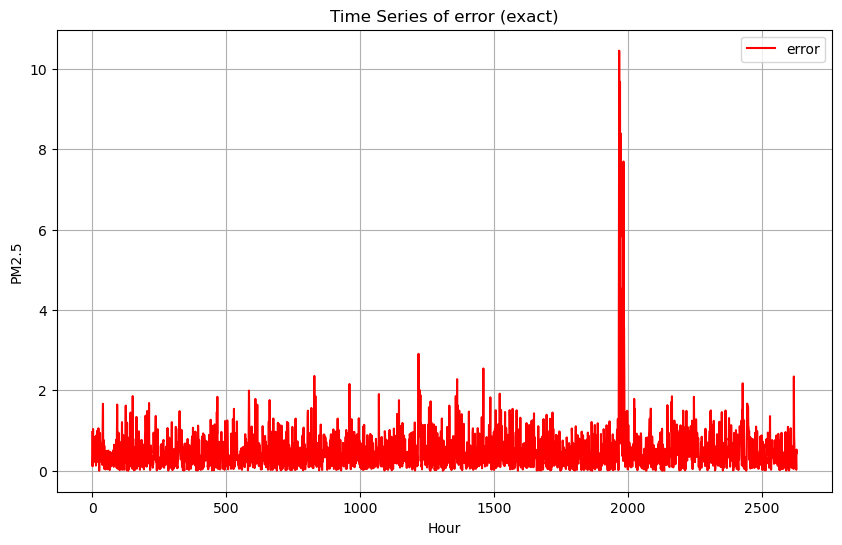

In [35]:
series = pd.Series(np.squeeze(np.abs(y_pred_avg[:, 0] - Y_test_avg[:, 0])))
plt.figure(figsize=(10, 6))
plt.plot(series, label=f'error', color='red')
plt.title('Time Series of error (exact)')
plt.xlabel('Hour')
plt.ylabel('PM2.5')
plt.legend()
plt.grid(True)
plt.show()

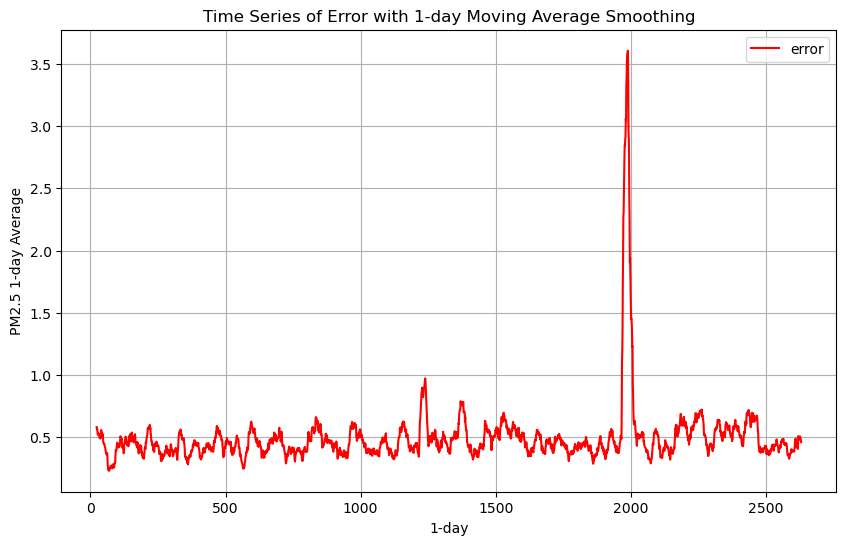

In [36]:
window_size = 24 # weekly average
smoothed_series = series.rolling(window=window_size).mean()

plt.figure(figsize=(10, 6))
plt.plot(smoothed_series, label=f'error', color='red')
plt.title('Time Series of Error with 1-day Moving Average Smoothing')
plt.xlabel('1-day')
plt.ylabel('PM2.5 1-day Average')
plt.legend()
plt.grid(True)
plt.show()

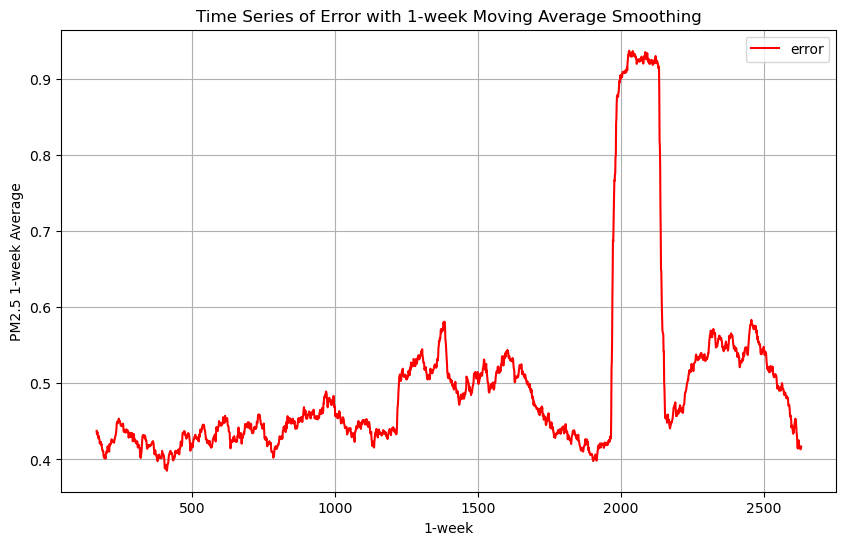

In [37]:
window_size = 168 # weekly average
smoothed_series = series.rolling(window=window_size).mean()

plt.figure(figsize=(10, 6))
plt.plot(smoothed_series, label=f'error', color='red')
plt.title('Time Series of Error with 1-week Moving Average Smoothing')
plt.xlabel('1-week')
plt.ylabel('PM2.5 1-week Average')
plt.legend()
plt.grid(True)
plt.show()

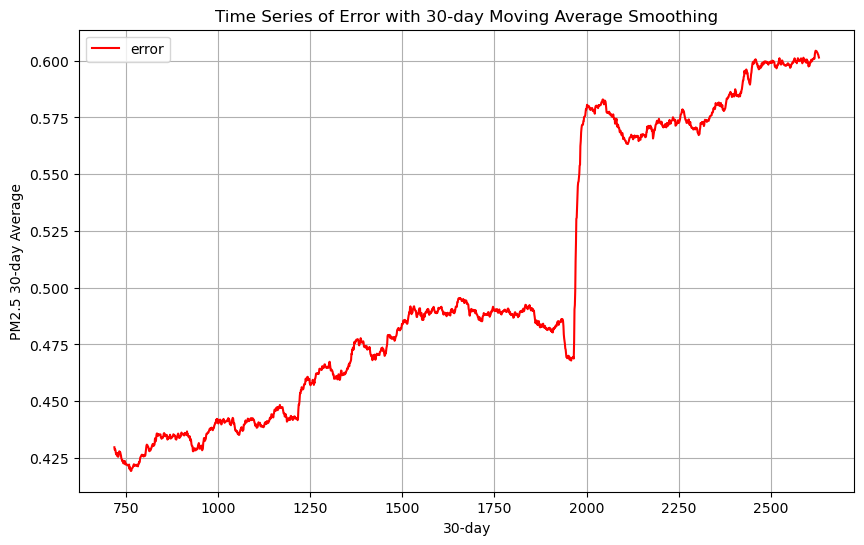

In [38]:
window_size = 720 # 30-day average
smoothed_series = series.rolling(window=window_size).mean()

plt.figure(figsize=(10, 6))
plt.plot(smoothed_series, label=f'error', color='red')
plt.title('Time Series of Error with 30-day Moving Average Smoothing')
plt.xlabel('30-day')
plt.ylabel('PM2.5 30-day Average')
plt.legend()
plt.grid(True)
plt.show()